# Algorytmy tekstowe
## Laboratorium 1
### Jakub Karbowski

# Add packages
Lepiej za dużo niż za mało.

In [18]:
using Pkg
Pkg.add([
    "Plots",
    "BenchmarkTools",
    "DataFrames",
    "Unitful",
])
using Plots
using BenchmarkTools
using DataFrames
using Unitful

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [2]:
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1

1

# Read data

In [3]:
texts = Vector{UInt8}.([
    "ababaabaababbabaabb",
    read("data/1997_714.txt"),
    read("data/passages-head.tsv"),
])

pats = Vector{UInt8}.([
    "abab",
    "art",
    "Ukraina",
])

for (i, t) = enumerate(texts)
    println("length(text$i) = $(length(t))")
end

length(text1) = 19
length(text2) = 254133
length(text3) = 86438335


# Naive algorithm

In [4]:
naive_find(T, P) = [i for i = 1:length(T)-length(P)+1
                      if @views T[i:i+length(P)-1] == P]

naive_find(texts[1], pats[1])

2-element Vector{Int64}:
 1
 9

# FSM

In [5]:
unicat(s::T, c) where T<:AbstractString = s*c
unicat(t::T, x) where T<:AbstractVector = [t;x]

fsm_init(P) =
    (symbols = unique(P);
    [ Dict([ s => filter(min(length(P), q+1):-1:0) do k
                      @views P[1:k] == unicat(P[1:q], s)[end-k+1:end]
                  end |> first
           for s=symbols ])
    for q=0:length(P) ])

fsm_find(T, Q) =
    foldl(enumerate(T), init=([], 0)) do (M, q), (i, c)
        q = get(Q[q+1], c, 0)
        q==length(Q)-1 && push!(M, i+1-q)
        M, q
    end |> first

fsm = fsm_init(pats[1])
fsm_find(texts[1], fsm)

2-element Vector{Any}:
 1
 9

# KMP

In [6]:
function kmp_init(pat)
    pi = [0]
    k = 0
    for q = 1:length(pat)-1
        while k > 0 && pat[k+1] != pat[q+1]
            k = pi[k]
        end
        if pat[k+1] == pat[q+1]
            k = k + 1
        end
        push!(pi, k)
    end
    pat, pi
end

function kmp_find(text, (pat, pi))
    matches = []
    q = 0
    for i = 0:length(text)-1
        while q > 0 && pat[q+1] != text[i+1]
            q = pi[q]
        end
        if pat[q+1] == text[i+1]
            q = q + 1
        end
        if q == length(pat)
            push!(matches, i + 2 - q)
            q = pi[q]
        end
    end
    matches
end

kmp = kmp_init(pats[1])
kmp_find(texts[1], kmp)

2-element Vector{Any}:
 1
 9

# Tests
Czy algorytmy dają te samy wyniki?

In [7]:
naive_matches = []
fsm_matches = []
kmp_matches = []
for (T, P) = zip(texts, pats)
    push!(naive_matches, naive_find(T, P))

    fsm = fsm_init(P)
    push!(fsm_matches, fsm_find(T, fsm))
    
    kmp = kmp_init(P)
    push!(kmp_matches, kmp_find(T, kmp))
end

println("naive == fsm: $(naive_matches == fsm_matches)")
println("naive == kmp: $(naive_matches == kmp_matches)")
println("fsm   == kmp: $(fsm_matches == kmp_matches)")

naive == fsm: true
naive == kmp: true
fsm   == kmp: true


# Searching
Szukanie zadanych wzorców w tekstach.

## Text 2

In [8]:
naive_find(texts[2], pats[2]) |> length

273

In [9]:
fsm_find(texts[2], fsm_init(pats[2])) |> length

273

In [10]:
kmp_find(texts[2], kmp_init(pats[2])) |> length

273

## Text 3

In [11]:
naive_find(texts[3], pats[3]) |> length

289

In [12]:
fsm_find(texts[3], fsm_init(pats[3])) |> length

289

In [13]:
kmp_find(texts[3], kmp_init(pats[3])) |> length

289

# Benchmarks

In [14]:
function bench(i)
    T, P = texts[i], pats[i]
    fsm = fsm_init(P)
    kmp = kmp_init(P)
    [
        (@belapsed naive_find($T, $P))u"s",
        (@belapsed fsm_init($P))u"s",
        (@belapsed fsm_find($T, $fsm))u"s",
        (@belapsed kmp_init($P))u"s",
        (@belapsed kmp_find($T, $kmp))u"s",
    ]
end
times = bench.(eachindex(texts))
;

## Find benchmark

In [15]:
results = DataFrame([
    :algo => ["Naive", "FSM", "KMP"]
    [Symbol("text$i") =>
        round.(u"ms", t[[1,3,5]], digits=2)
    for (i, t)=enumerate(times)]
])

,algo,text1,text2,text3
,String,Quantity…,Quantity…,Quantity…
1,Naive,0.0 ms,1.45 ms,457.3 ms
2,FSM,0.0 ms,1.72 ms,1066.23 ms
3,KMP,0.0 ms,0.91 ms,278.33 ms


## Init benchmark

In [16]:
results = DataFrame([
    :algo => ["FSM", "KMP"]
    [Symbol("text$i") =>
        round.(u"μs", t[[2,4]], digits=2)
    for (i, t)=enumerate(times)]
])

# TU POWINNY BYĆ MIKROSEKUNDY
# tylko pdf nie umie w unicode (\mu)

,algo,text1,text2,text3
,String,Quantity…,Quantity…,Quantity…
1,FSM,6.03 μs,6.03 μs,30.04 μs
2,KMP,0.1 μs,0.09 μs,0.12 μs


# Wstępne wnioski
Algorytmy od najszybszego do najwolniejszego:
- KMP
- Naiwny
- FSM

Prędkość algorytmu naiwnego najprawdopodobniej
wynika z optymalizacji wbudowanych funkcji
porównywania tablic.

Prostota algorytmu KMP (same ify, pętle i indeksowania)
sprawia, że skompilowany program jest taki sam
jakby napisało się go w C.
Moja próba uproszczenia kodu FSM nie przyniosła
jednak znaczących zmian. Sugeruje to, że algorytm
KMP jest po prostu szybszy.

Inicializacja algorytmu KMP jest nieporównywalnie
szybsza od FSM (najprawdopodobniej poniżej rozdzielczości
zegara).

# Trudne przypadki

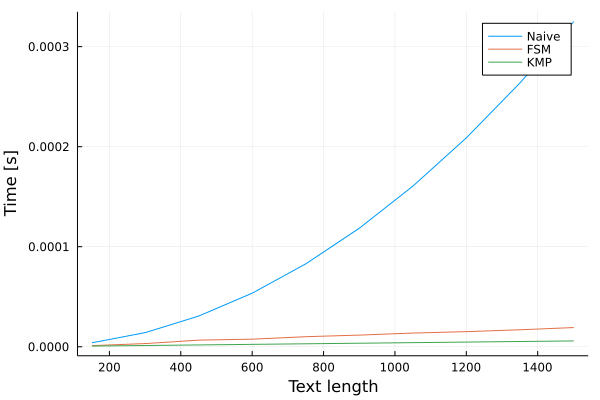

In [17]:
xs = []
ysnaive = []
ysfsm = []
yskmp = []

for i = 50:50:500
    pat = Vector{UInt8}(repeat('a', i) * 'b' * repeat('a', i))
    txt = Vector{UInt8}(repeat('a', 2*i) * 'b' * repeat('a', i))
    
    tnaive = @belapsed naive_find($txt, $pat) seconds=0.01
    
    fsm = fsm_init(pat)
    tfsm = @belapsed fsm_find($txt, $fsm) seconds=0.01
    
    kmp = kmp_init(pat)
    tkmp = @belapsed kmp_find($txt, $kmp) seconds=0.01

    push!(xs, length(txt))
    push!(ysnaive, tnaive)
    push!(ysfsm, tfsm)
    push!(yskmp, tkmp)
end

plot(
    xs,
    [ysnaive, ysfsm, yskmp],
    label=["Naive" "FSM" "KMP"],
    xlabel="Text length",
    ylabel="Time [s]",
)

## Co się stało?
Dla wzorca
$\underbrace{a\dots a}_n\,b\,\underbrace{a\dots a}_n$,
i tekstu
$\underbrace{a\dots a}_{2n}\,b\,\underbrace{a\dots a}_n$,
algorytm naiwny ma złożoność $O(n^2)$.

## Czasy inicjalizacji
Czasy tworzenia funkcji przejścia KMP
są na tyle małe w stosunku do FSM,
że nie ma sensu ich porównywać.

# Wnioski
Dla krótkich wzorców algorytm naiwny jest szybszy od FSM.
Jedynie dla bardziej skomplikowanych wzorców widać
przewagę FSM.

Algorytm KMP wygrywa w każdym przypadku.
Być może wynika to z prostej implementacji,
która jest optymalnie kompilowana przez Julię.